In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
%matplotlib inline

In [139]:
##
## 1. Data ingest and data cleaning
##

df = pd.read_csv("flights.csv", low_memory=False)

In [140]:
df = df[df["MONTH"] == 11]
df.shape

(467972, 31)

In [141]:
print(df.dtypes)
print(df.head())

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object
         YEAR  MONTH  DAY

In [142]:
# import datetime
# dt = np.empty(df.shape[0], dtype = datetime.date)
# for i in range(0, df.shape[0]):
#     dt[i] = datetime.date(df.YEAR[i], df.MONTH[i], df.DAY[i])
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [143]:
df['DATE'].head()

4871877   2015-11-01
4871878   2015-11-01
4871879   2015-11-01
4871880   2015-11-01
4871881   2015-11-01
Name: DATE, dtype: datetime64[ns]

In [144]:
# format date

def format_time(data):
    if pd.isnull(data): return np.nan
    else:
        if data == 2400: data = 0
        data = "{0:04d}".format(int (data))
        return datetime.time(int (data[0:2]),int (data[2:4]))

In [145]:
# Get necessary records

df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(format_time)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_time)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_time)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_time)

df = df.loc[:,['DATE',
                       'AIRLINE',
                       'ORIGIN_AIRPORT',
                       'DESTINATION_AIRPORT',
                       'SCHEDULED_DEPARTURE',
                       'SCHEDULED_ARRIVAL',
                       'DEPARTURE_TIME',
                       'DEPARTURE_DELAY',
                       'ARRIVAL_TIME',
                       'ARRIVAL_DELAY',
                       'SCHEDULED_TIME',
                       'ELAPSED_TIME']]
df.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
4871877,2015-11-01,NK,LAS,MSP,00:05:00,04:02:00,00:07:00,2.0,04:04:00,2.0,177.0,177.0
4871878,2015-11-01,UA,SFO,ORD,00:14:00,05:32:00,00:19:00,5.0,05:10:00,-22.0,258.0,231.0
4871879,2015-11-01,AA,LAX,MIA,00:15:00,07:11:00,00:06:00,-9.0,07:19:00,8.0,296.0,313.0
4871880,2015-11-01,UA,LAX,ORD,00:31:00,05:39:00,00:27:00,-4.0,05:18:00,-21.0,248.0,231.0
4871881,2015-11-01,UA,LAS,IAH,00:41:00,04:33:00,NaN,NaN,NaN,NaN,172.0,NaN


In [146]:
## show the portion of missing value

col1 = df.columns
col2 = df.isnull().sum()
col3 = (1 - col2 / len(df)) * 100

missing_df = pd.DataFrame({"variable":col1, "missing values":col2, "filling factor (%)":col3})
missing_df

,variable,missing values,filling factor (%)
DATE,DATE,0,100.000000
AIRLINE,AIRLINE,0,100.000000
ORIGIN_AIRPORT,ORIGIN_AIRPORT,0,100.000000
DESTINATION_AIRPORT,DESTINATION_AIRPORT,0,100.000000
SCHEDULED_DEPARTURE,SCHEDULED_DEPARTURE,0,100.000000
SCHEDULED_ARRIVAL,SCHEDULED_ARRIVAL,0,100.000000
DEPARTURE_TIME,DEPARTURE_TIME,4339,99.072808
DEPARTURE_DELAY,DEPARTURE_DELAY,4339,99.072808
ARRIVAL_TIME,ARRIVAL_TIME,4817,98.970665
ARRIVAL_DELAY,ARRIVAL_DELAY,5605,98.802279


In [147]:
df.dropna(inplace = True)
df.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
4871877,2015-11-01,NK,LAS,MSP,00:05:00,04:02:00,00:07:00,2.0,04:04:00,2.0,177.0,177.0
4871878,2015-11-01,UA,SFO,ORD,00:14:00,05:32:00,00:19:00,5.0,05:10:00,-22.0,258.0,231.0
4871879,2015-11-01,AA,LAX,MIA,00:15:00,07:11:00,00:06:00,-9.0,07:19:00,8.0,296.0,313.0
4871880,2015-11-01,UA,LAX,ORD,00:31:00,05:39:00,00:27:00,-4.0,05:18:00,-21.0,248.0,231.0
4871882,2015-11-01,AS,ANC,SEA,00:45:00,04:06:00,00:42:00,-3.0,03:58:00,-8.0,201.0,196.0


In [148]:
##
## 2. Comparing Airlines
##

airlines_names = pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [149]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

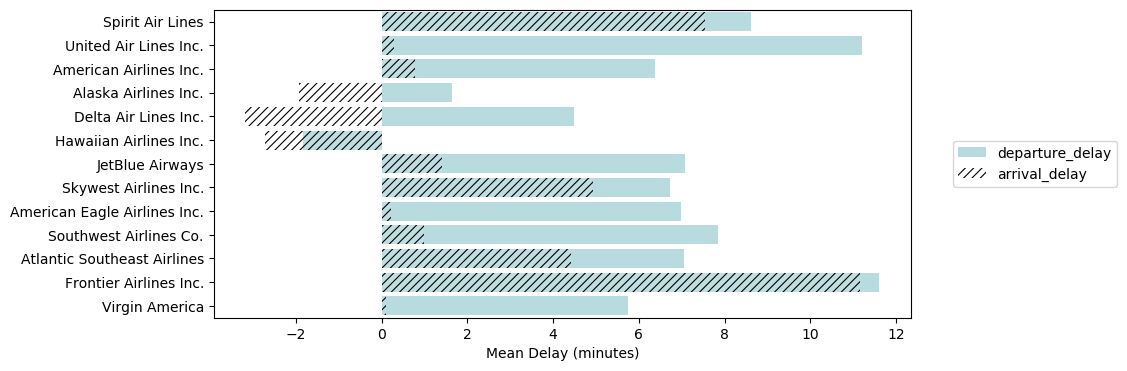

In [150]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 0.8

fig = plt.figure(1, figsize = (9, 4))
ax = sns.barplot(x = 'DEPARTURE_DELAY', y = 'AIRLINE', data = df, color = 'powderblue', ci = None, label = 'departure_delay')
ax = sns.barplot(x = 'ARRIVAL_DELAY', y = 'AIRLINE', data = df, color = 'white', hatch = '////', alpha = 0.1, ci = None, label = 'arrival_delay')
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean Delay (minutes)')
plt.legend(loc = 'center left', bbox_to_anchor = (1.05, 0.5))
plt.show()